# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [147]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [165]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS/2014/CFS_APCP_Basin_Sums.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS/2014/CFS_TMP_Basin_Avgs.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS/2014/CFS_EVAP_Basin_Sums.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Defined Functions

In [4]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [5]:
def convert_kg_to_cms(df):

    # Calculate the number of seconds for each month
    df['seconds'] = df.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # Convert millimeters to meters
    df['WaterErie_m3'] = df['WaterErie'] / 1000
    df['WaterOntario_m3'] = df['WaterOntario'] / 1000
    df['WaterSuperior_m3'] = df['WaterSuperior'] / 1000
    df['WaterMichHuron_m3'] = (df['WaterMichigan'] + df['WaterHuron']) / 1000

    # Convert the data to cubic meters per second
    df['WaterErie_cms'] = df['WaterErie_m3'] / df['seconds']
    df['WaterOntario_cms'] = df['WaterOntario_m3'] / df['seconds']
    df['WaterSuperior_cms'] = df['WaterSuperior_m3'] / df['seconds']
    df['WaterMichHuron_cms'] = df['WaterMichHuron_m3'] / df['seconds']
    
    return df

In [6]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [166]:
# Read in GLCC RNBS data
data_4 = pd.read_csv(dir + 'Input/rnbs_glcc.csv', sep=',')

# Ensure 'Date' column is treated as string and modified as necessary
date_strs = data_4['Date'].astype(str)

date_rnbs = []

for date_str in date_strs:
    # Insert leading zero before month (if necessary)
    if len(date_str) == 6:
        date_str = date_str[:4] + '0' + date_str[4:]

    # Insert leading zero before day (if necessary)
    if len(date_str) == 7:
        date_str = date_str[:6] + '0' + date_str[6:]

    # Convert to datetime object
    datetime_obj = datetime.strptime(date_str, '%Y%m%d')

    # Format the datetime object as a string in the desired format
    date_tmp = datetime_obj.strftime('%Y-%m-%d')

    # Append formatted date to list
    date_rnbs.append(date_tmp)

# Replace the original 'Date' column with formatted dates
data_4['Date'] = date_rnbs

# Convert 'Date' column to datetime format
data_4['Date'] = pd.to_datetime(data_4['Date'])

# Add a new column 'Month' extracting month from 'Date'
data_4['Month'] = data_4['Date'].dt.month

# Select only the data that matches with the CFSR dates
start_date = '2014-01-01'
end_date = '2014-12-01'
obs = data_4[(data_4['Date'] >= start_date) & (data_4['Date'] <= end_date)]

su_rnbs = obs['sup']
er_rnbs = obs['eri']
on_rnbs = obs['ont']
mh_rnbs = obs['mic_hur']

In [167]:
print(obs)

           Date        sup    mic_hur         eri         ont  Month
1368 2014-01-01  -16.34666   44.23887  136.007600  156.885500      1
1369 2014-02-01   45.18005   40.78583  111.418000  129.051000      2
1370 2014-03-01   51.65544   81.83045  164.474300  168.091600      3
1371 2014-04-01  171.79810  266.63110  277.524800  614.076700      4
1372 2014-05-01  270.37370  226.23710  222.462000  329.179400      5
1373 2014-06-01  165.78680  169.47270   92.848370  241.292800      6
1374 2014-07-01  143.85060   71.97412   30.575340  142.877900      7
1375 2014-08-01  115.40740   91.45756   -7.380255   99.454210      8
1376 2014-09-01  105.98960   79.19076   16.324990   -2.711155      9
1377 2014-10-01   91.54129   81.37202    1.054322   32.217560     10
1378 2014-11-01   46.19249   61.44493  -41.832780   25.755980     11
1379 2014-12-01   12.09653   77.93376  -14.760510  121.866400     12


## Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [168]:
# Convert Total Precipitation to cms
pcp_data = convert_kg_to_cms(pcp_data)

# Convert Total Evaporation to cms
evap_data = convert_kg_to_cms(evap_data)

In [169]:
print(pcp_data)

           cfsrun  year  month     BasinErie     WaterErie      LandErie  \
0      2014010100  2014      1  6.530929e+12  1.135046e+12  6.055831e+12   
1      2014010100  2014      2  3.061929e+12  5.104406e+11  3.065296e+12   
2      2014010100  2014      3  7.964349e+12  1.319356e+12  7.665141e+12   
3      2014010100  2014      4  9.718082e+12  1.441213e+12  9.887530e+12   
4      2014010100  2014      5  3.514525e+12  5.194099e+11  3.561417e+12   
...           ...   ...    ...           ...           ...           ...   
12195  2014123118  2015      5  7.861279e+12  1.244701e+12  7.673612e+12   
12196  2014123118  2015      6  7.793712e+12  1.168518e+12  7.978140e+12   
12197  2014123118  2015      7  7.384928e+12  1.014841e+12  7.936556e+12   
12198  2014123118  2015      8  9.843306e+12  1.387222e+12  1.027523e+13   
12199  2014123118  2015      9  8.210123e+12  1.362768e+12  7.580521e+12   

       BasinOntario  WaterOntario   LandOntario    BasinHuron  ...  \
0      7.210699e+

In [170]:
# Features
X = pd.DataFrame({
    'su_pcp': pcp_data['WaterSuperior_cms'],
    'er_pcp': pcp_data['WaterErie_cms'],
    'on_pcp': pcp_data['WaterOntario_cms'],
    'mh_pcp': pcp_data['WaterMichHuron_cms'], #data_1['WaterMichigan']+data_1['WaterHuron'], # add the sums
    'su_evap': evap_data['WaterSuperior_cms'],
    'er_evap': evap_data['WaterErie_cms'],
    'on_evap': evap_data['WaterOntario_cms'],
    'mh_evap': evap_data['WaterMichHuron_cms'], #data_2['WaterMichigan']+data_2['WaterHuron'], # add the sums
    'su_tmp': tmp_data['WaterSuperior'],
    'er_tmp': tmp_data['WaterErie'],
    'on_tmp': tmp_data['WaterOntario'],
    'mh_tmp': (tmp_data['WaterMichigan']+tmp_data['WaterHuron'])/2 # take the average temp
})

### Predict Components using GP
Scale the data and run it through the trained GP model. Put the results into a new dataframe.

In [171]:
# Predict RNBS using GP

# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
print(df_y_pred)

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


               sup          eri          ont          mih
0       547.567908  1756.046054  1884.793498  3683.822697
1      -166.947898   606.759741   859.010278  1279.921824
2      -534.633061  1770.881128  1467.129829  2849.766863
3      3883.250577  1876.361881  2333.303761  7910.790666
4      1745.966768  -269.667087   388.503557   498.756625
...            ...          ...          ...          ...
12195  1859.228160   530.108797   618.893676  3154.813634
12196  2719.106973    61.649846   563.624349  2593.358782
12197  2419.726364  -346.128821   173.137063   705.397614
12198  1964.669172   126.334164    34.001896  2177.886835
12199  3810.489820   494.782611   725.814831  5228.738403

[12200 rows x 4 columns]


In [172]:
df = pd.DataFrame()
df['cfsrun'] = pcp_data['cfsrun']
df['month'] = pcp_data['month'].astype(int)
df['year'] = pcp_data['year'].astype(int)

In [173]:
df_y = pd.merge(df, df_y_pred, left_index=True, right_index=True, how='inner')

In [174]:
print(df_y)

           cfsrun  month  year          sup          eri          ont  \
0      2014010100      1  2014   547.567908  1756.046054  1884.793498   
1      2014010100      2  2014  -166.947898   606.759741   859.010278   
2      2014010100      3  2014  -534.633061  1770.881128  1467.129829   
3      2014010100      4  2014  3883.250577  1876.361881  2333.303761   
4      2014010100      5  2014  1745.966768  -269.667087   388.503557   
...           ...    ...   ...          ...          ...          ...   
12195  2014123118      5  2015  1859.228160   530.108797   618.893676   
12196  2014123118      6  2015  2719.106973    61.649846   563.624349   
12197  2014123118      7  2015  2419.726364  -346.128821   173.137063   
12198  2014123118      8  2015  1964.669172   126.334164    34.001896   
12199  2014123118      9  2015  3810.489820   494.782611   725.814831   

               mih  
0      3683.822697  
1      1279.921824  
2      2849.766863  
3      7910.790666  
4       498.756625

Currently, we are only storing 1 set of model results

In [175]:
df_y.to_csv(dir+f'RNBS_forecasts_2014.csv',sep=',',index=False)

Convert component units from [cms] to [mm]

In [176]:
df_y_mm = convert_cms_to_mm(df_y)

In [177]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].median().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(df_y_mm,'sup')
mean_er, min_er, max_er = mean_min_max(df_y_mm,'eri')
mean_on, min_on, max_on = mean_min_max(df_y_mm,'ont')
mean_mh, min_mh, max_mh = mean_min_max(df_y_mm,'mih')

In [179]:
df_y_mm_filtered = df_y_mm[(df_y_mm['year'] == 2014)]
print(df_y_mm_filtered)

           cfsrun  month  year         sup         eri         ont  \
0      2014010100      1  2014   17.864305  183.332440  265.570567   
1      2014010100      2  2014   -4.919551   57.215871  109.322829   
2      2014010100      3  2014  -17.442308  184.881232  206.721055   
3      2014010100      4  2014  122.603573  189.574352  318.161047   
4      2014010100      5  2014   56.961855  -28.153433   54.740803   
...           ...    ...   ...         ...         ...         ...   
11898  2014120318     12  2014   -5.064605   62.213583  144.125320   
11908  2014120400     12  2014    3.932337   75.365117  121.790775   
11918  2014120406     12  2014  -18.846305  196.974438  213.925267   
11928  2014120412     12  2014   13.107949  101.721816  171.572327   
11938  2014120418     12  2014   25.691774   83.720962  182.793162   

              mih  seconds  
0      154.872164  2678400  
1       48.602032  2419200  
2      119.807493  2678400  
3      321.850436  2592000  
4       20.968

Begin plotting

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

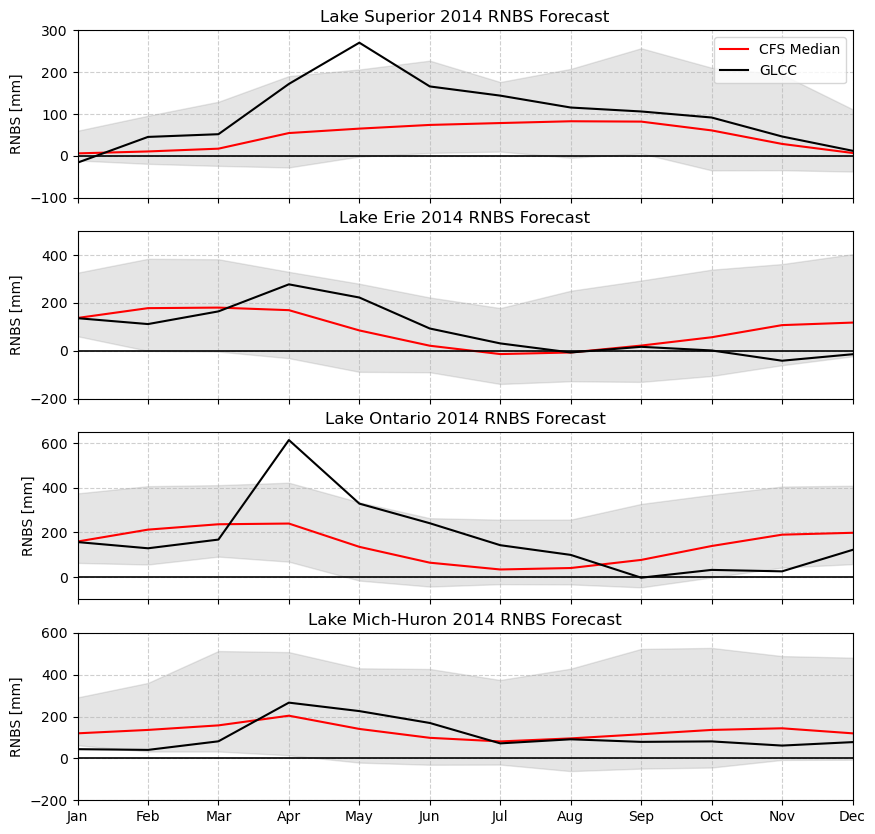

In [182]:
x_values = np.arange(0,12,1)  # x-axis values

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(x_values, mean_su['sup'][0:12], color='red', linestyle='-', linewidth=1.5, label='CFS Median')
axs[0].plot(x_values, su_rnbs, color='black', linestyle='-', linewidth=1.5, label='GLCC')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_su['sup'][0:12], max_su['sup'][0:12], color='gray', alpha=0.2)
axs[0].set_ylabel('RNBS [mm]')
axs[0].set_title('Lake Superior 2014 RNBS Forecast')
axs[0].set_ylim(-100, 300)
axs[0].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[0].set_xticks(np.arange(0,12,1))
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_er['eri'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[1].plot(x_values, er_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_er['eri'][0:12], max_er['eri'][0:12], color='gray', alpha=0.2)
axs[1].set_ylabel('RNBS [mm]')
axs[1].set_title('Lake Erie 2014 RNBS Forecast')
axs[1].set_ylim(-200, 500)
axs[1].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[1].set_xticks(np.arange(0,12,1))
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on['ont'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[2].plot(x_values, on_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on['ont'][0:12], max_on['ont'][0:12], color='gray', alpha=0.2)
axs[2].set_ylabel('RNBS [mm]')
axs[2].set_title('Lake Ontario 2014 RNBS Forecast')
axs[2].set_ylim(-100, 650)
axs[2].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[2].set_xticks(np.arange(0,12,1))
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh['mih'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[3].plot(x_values, mh_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh['mih'][0:12], max_mh['mih'][0:12], color='gray', alpha=0.2)
axs[3].set_ylabel('RNBS [mm]')
axs[3].set_title('Lake Mich-Huron 2014 RNBS Forecast')
axs[3].set_ylim(-200, 600)
axs[3].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[3].set_xticks(np.arange(0,12,1))
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels([calendar.month_abbr[mean_mh['month'][j]] for j in range(12)])

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\2601309738.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\2601309738.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


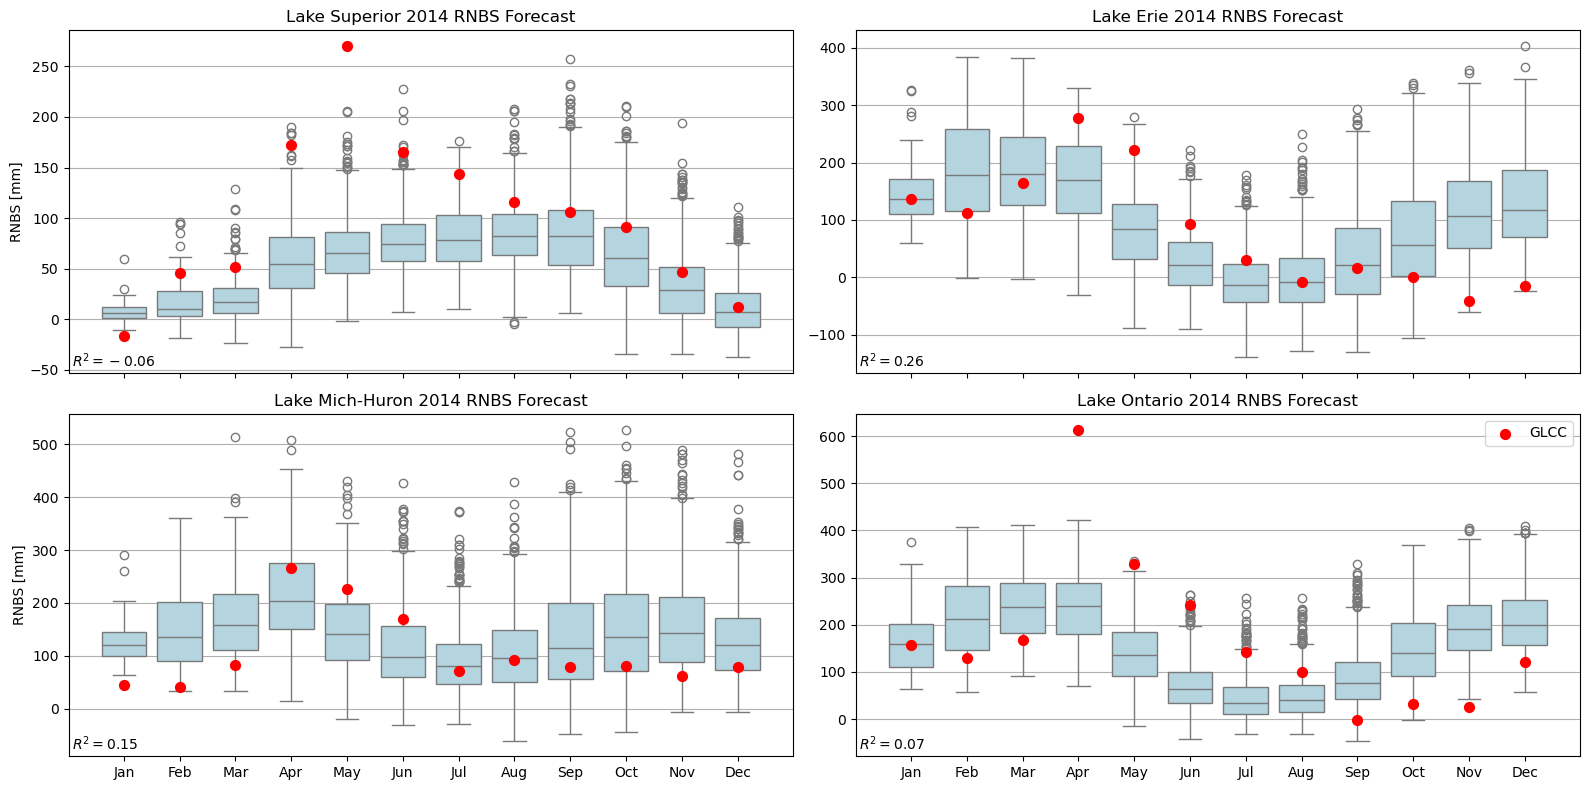

In [183]:
import seaborn as sns
from sklearn.metrics import r2_score

months = np.arange(0, 12)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# First boxplot
sns.boxplot(x='month', y='sup', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 0])
axes[0, 0].set_title('Lake Superior 2014 RNBS Forecast')
# Scatter plot for observations
axes[0, 0].scatter(obs['Month']-1, obs['sup'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 0].set_ylabel('RNBS [mm]')
axes[0, 0].set_xlabel('')
axes[0, 0].set_xticklabels('')
axes[0, 0].grid(axis='y')

r2_1 = r2_score(obs['sup'],df_y_mm_filtered.groupby('month')['sup'].median())
axes[0, 0].text(0.005, 0.009, f'$R^2 = {r2_1:.2f}$', ha='left', va='bottom', transform=axes[0, 0].transAxes)

# Second boxplot
sns.boxplot(x='month', y='eri', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Lake Erie 2014 RNBS Forecast')
# Scatter plot for observations
axes[0, 1].scatter(obs['Month']-1, obs['eri'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticklabels('')
axes[0, 1].grid(axis='y')

r2_2 = r2_score(obs['eri'],df_y_mm_filtered.groupby('month')['eri'].median())
axes[0, 1].text(0.005, 0.009, f'$R^2 = {r2_2:.2f}$', ha='left', va='bottom', transform=axes[0, 1].transAxes)

# Third boxplot
sns.boxplot(x='month', y='mih', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 0])
axes[1, 0].set_title('Lake Mich-Huron 2014 RNBS Forecast')
# Scatter plot for observations
axes[1, 0].scatter(obs['Month']-1, obs['mic_hur'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 0].set_ylabel('RNBS [mm]')
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].grid(axis='y')

r2_3 = r2_score(obs['mic_hur'],df_y_mm_filtered.groupby('month')['mih'].median())
axes[1, 0].text(0.005, 0.009, f'$R^2 = {r2_3:.2f}$', ha='left', va='bottom', transform=axes[1, 0].transAxes)

# Fourth boxplot
sns.boxplot(x='month', y='ont', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 1])
axes[1, 1].set_title('Lake Ontario 2014 RNBS Forecast')
# Scatter plot for observations
axes[1, 1].scatter(obs['Month']-1, obs['ont'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 1].grid(axis='y')
axes[1, 1].legend()

r2_4 = r2_score(obs['ont'],df_y_mm_filtered.groupby('month')['ont'].median())
axes[1, 1].text(0.005, 0.009, f'$R^2 = {r2_4:.2f}$', ha='left', va='bottom', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

In [164]:
# Calculate important statistics
stats = df_y_mm_filtered.groupby('month')['mih'].describe()
print("Important values:\n", stats)

Important values:
         count        mean        std        min         25%         50%  \
month                                                                     
1        96.0  147.561776  65.129004  37.151777  105.544173  133.049028   
2       212.0  113.921754  53.589853  17.549025   75.995269  104.633857   
3       324.0  166.229172  91.657843  16.774826   89.683861  154.784663   
4       448.0  200.058484  98.638856   4.909243  125.499832  183.181960   
5       564.0  126.100136  80.623030 -48.755846   68.451523  112.291809   
6       672.0   89.702666  68.600178 -45.278379   43.306190   74.403928   
7       788.0   56.095150  52.125485 -69.819651   19.790410   50.185117   
8       912.0   57.301317  51.322189 -52.470353   21.981044   49.941617   
9      1036.0   74.422424  72.293883 -89.071502   25.081591   65.263563   
10     1156.0   90.218165  79.982790 -87.735831   34.248795   78.391561   
11     1156.0  109.171865  77.758431 -47.335164   53.952417   99.378338   
12    